In [1]:
import re
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sktime
from sktime.utils.load_data import load_from_tsfile_to_dataframe
from sktime.utils.load_data import load_from_ucr_tsv_to_dataframe
from sktime.utils.load_data import load_from_arff_to_dataframe
from sktime.transformers.series_as_features.shapelets import ContractedShapeletTransform
import seaborn as sns; sns.set()

from sklearn.model_selection import train_test_split

from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix

In [8]:
np.random.seed(123)

___

In [9]:
DATA_PATH = '../data/'

## sktime series

In [16]:
X, y = load_from_arff_to_dataframe(os.path.join(DATA_PATH, 'FordA_TRAIN.arff'))
X.head()

dim_0
0  0     -0.797172
1     -0.664392
2     -0.37301...
1  0      0.804855
1      0.634629
2      0.37347...
2  0      0.727985
1      0.111284
2     -0.49912...
3  0     -0.234439
1     -0.502157
2     -0.73248...
4  0     -0.171328
1     -0.062285
2      0.23582...

In [17]:
(pd.Series(y).value_counts(normalize=True)*100).round(2)

-1    51.26
1     48.74
dtype: float64

In [18]:
train_X, test_X, train_y, test_y = train_test_split(X, y, random_state=42)

In [24]:
contract_shapelet_kwargs = dict(
    time_contract_in_mins=10,
    num_candidates_to_sample_per_case=15,
    verbose=2
)

st = ContractedShapeletTransform(**contract_shapelet_kwargs)
st.fit(train_X, train_y)

visiting series: 2517 (#1)
Candidate rejected. 00:-45 remaining
Candidate rejected. -2:-24 remaining


KeyboardInterrupt: 

In [23]:
st.shapelets

[]

# Get Data

In [10]:
train = pd.read_csv(os.path.join(DATA_PATH, "fordA_train.csv"), header=None) \
          .drop(0, axis=1)

In [11]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3601 entries, 0 to 3600
Columns: 501 entries, 1 to 501
dtypes: float64(501)
memory usage: 13.8 MB


In [12]:
train_X = train.iloc[:, 1:]
train_y = train.iloc[:, 0]

In [13]:
train_X.columns = list(range(len(train_X.columns)))

In [15]:
(train_y.value_counts(normalize=True)*100).round(2)

-1.0    51.26
 1.0    48.74
Name: 1, dtype: float64

In [49]:
train_melt = (train_X
              .reset_index()
              .melt(id_vars='index', var_name='ts', value_name='value')
              .set_index(['index', 'ts'])
              
)

In [50]:
train_melt

value
index ts           
0     0   -0.797172
1     0    0.804855
2     0    0.727985
3     0   -0.234439
4     0   -0.171328
...             ...
3596  499 -2.603753
3597  499 -0.393755
3598  499 -0.270722
3599  499 -0.280709
3600  499  0.573116

[1800500 rows x 1 columns]

In [79]:
idx_positive = np.where(train_y == 1)[0]
idx_negative = np.where(train_y == -1)[0]

In [89]:
n_samples = 6
random_positive_idx = np.random.choice(idx_positive, size=6, replace=False)
random_negative_idx = np.random.choice(idx_negative, size=6, replace=False)

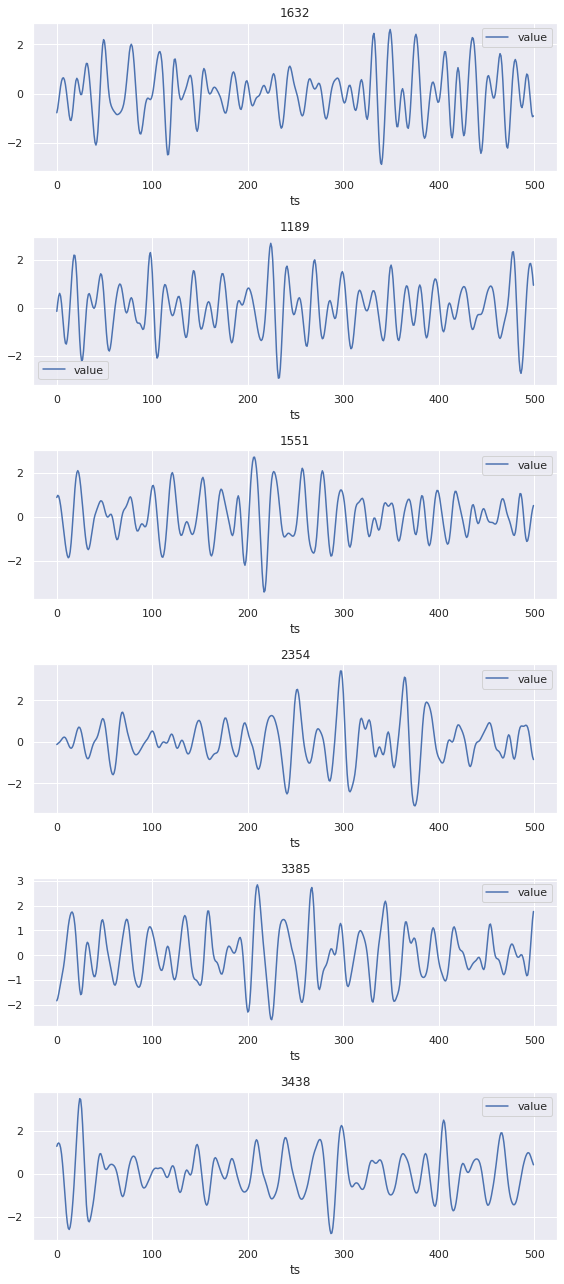

In [90]:
f, axs = plt.subplots(figsize=(8, 3*n_samples), nrows=n_samples)
for i, idx in enumerate(random_positive_idx):
    train_melt.loc[idx].plot(ax=axs[i])
    axs[i].set_title(idx)

plt.tight_layout()
plt.show()

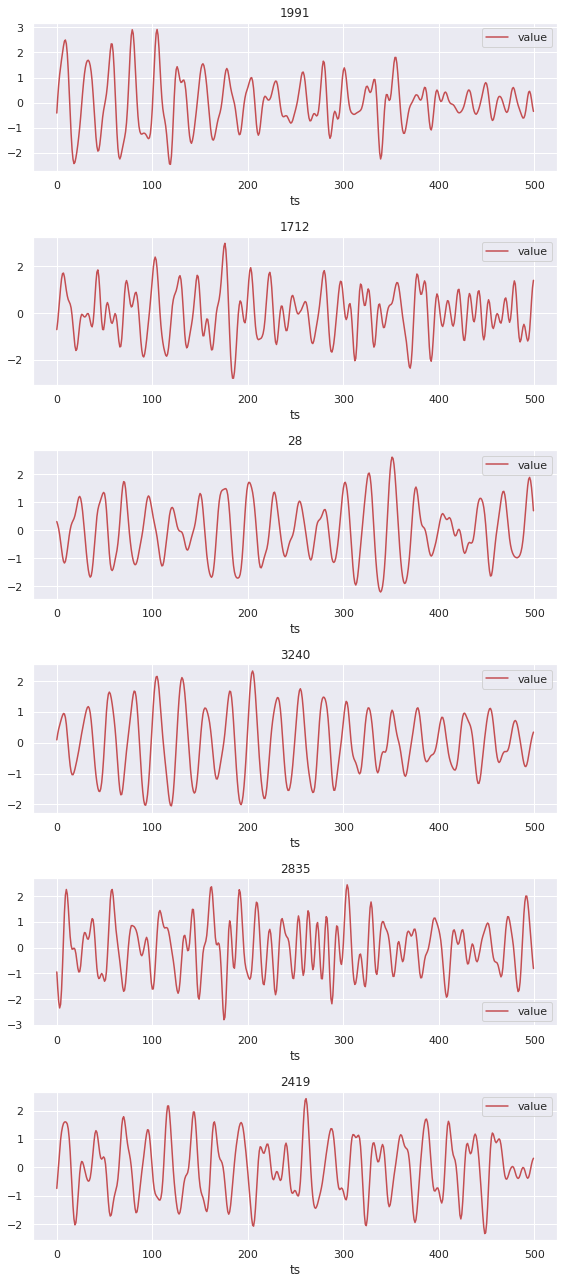

In [91]:
f, axs = plt.subplots(figsize=(8, 3*n_samples), nrows=n_samples)
for i, idx in enumerate(random_negative_idx):
    train_melt.loc[idx].plot(ax=axs[i], c='r')
    axs[i].set_title(idx)

plt.tight_layout()
plt.show()

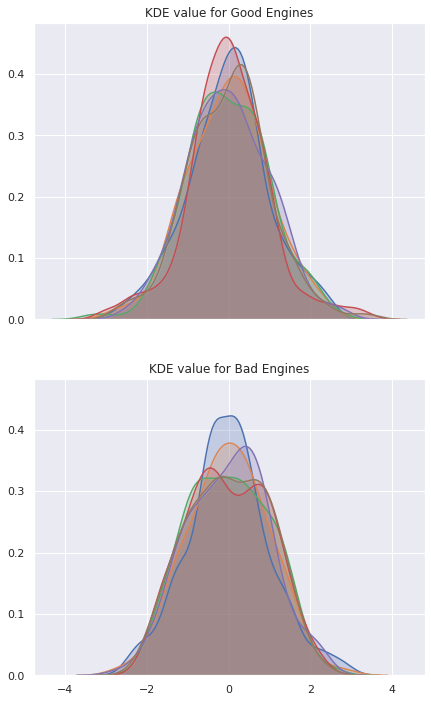

In [105]:
f, axs = plt.subplots(figsize=(7, 12), nrows=2,
                      sharex=True, sharey=True)
for idx in random_positive_idx:
    sns.distplot(train_melt.loc[idx], hist=False,
                 kde_kws={'shade': True}, ax=axs[0])
    axs[0].set_title('KDE value for Good Engines')

for idx in random_negative_idx:
    sns.distplot(train_melt.loc[idx], hist=False,
                 kde_kws={'shade': True}, ax=axs[1])
    axs[1].set_title('KDE value for Bad Engines')

plt.show()

**Obs**
- bad seems to be somewhat less normal => use normality test to separate?

# 1st approach: 

In [112]:
from tsfresh.feature_extraction import ComprehensiveFCParameters
from tsfresh.feature_extraction import extract_features

In [119]:
train_stacked = train_melt.reset_index()

In [132]:
fc_parameters = {
    "skewness": None,
    "kurtosis": None
}

In [121]:
extracted = extract_features(train_stacked, column_id='index',
                             column_sort='ts', default_fc_parameters=fc_parameters)

Feature Extraction: 100%|██████████| 10/10 [00:03<00:00,  3.31it/s]


In [122]:
extracted.head()

variable  value__kurtosis  value__skewness
id                                        
0               -0.860876         0.076155
1               -0.434198        -0.019140
2               -0.040417        -0.278253
3                0.039097        -0.087142
4                1.695826        -0.632179

In [124]:
extracted.isna().sum()

variable
value__kurtosis    0
value__skewness    0
dtype: int64

In [125]:
train_y.shape

(3601,)

In [126]:
extracted.shape

(3601, 2)

In [128]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

In [129]:
logreg = LogisticRegression()

In [130]:
scores = cross_val_score(logreg, extracted.values, train_y.values, cv=10, scoring='recall')

In [131]:
np.mean(scores)

0.36237662337662335

## MrSEQL

In [136]:
from sktime.classification.shapelet_based import MrSEQLClassifier

In [154]:
df = pd.DataFrame(data=[np.nan],
                  columns=['series'])
df

series
0     NaN